Traffic Sign Classification

This notebook showcases the developed Traffic Sign Recognition model, over the GTSRB - German Traffic Sign dataset, using PyTorch. The goal is to provide a clear way to visualize and explain the code. This way, we'll go over multiple sections:

    1) Data Profiling
    2) Data Preparation
    3) Model Definition and Profiling
    4) Training
    5) Evaluation

1) Data Profiling:

Loading serialized data for data profiling, using pickle since JSON creates much larger file sizes:

In [11]:
import codecs, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pickle
from tqdm import tqdm
from .autonotebook import tqdm as notebook_tqdm

num_classes = 43
IMAGE_SIZE = 32

train_data = pickle.load(open("serialized_data/train_data_numpy", "rb"))
train_labels = pickle.load(open("serialized_data/train_labels_numpy", "rb"))
test_data = pickle.load(open("serialized_data/test_data_numpy", "rb"))

label_json = codecs.open("DataProfiling/label_names.json", 'r', encoding='utf-8').read()
label_names = json.loads(label_json)

Dataset statistics and preview:


Shape of training data:  (39209, 32, 32, 3)
Shape of test data:  (12630, 32, 32, 3)
Number of classes: 43
Images resized to 32 x 32


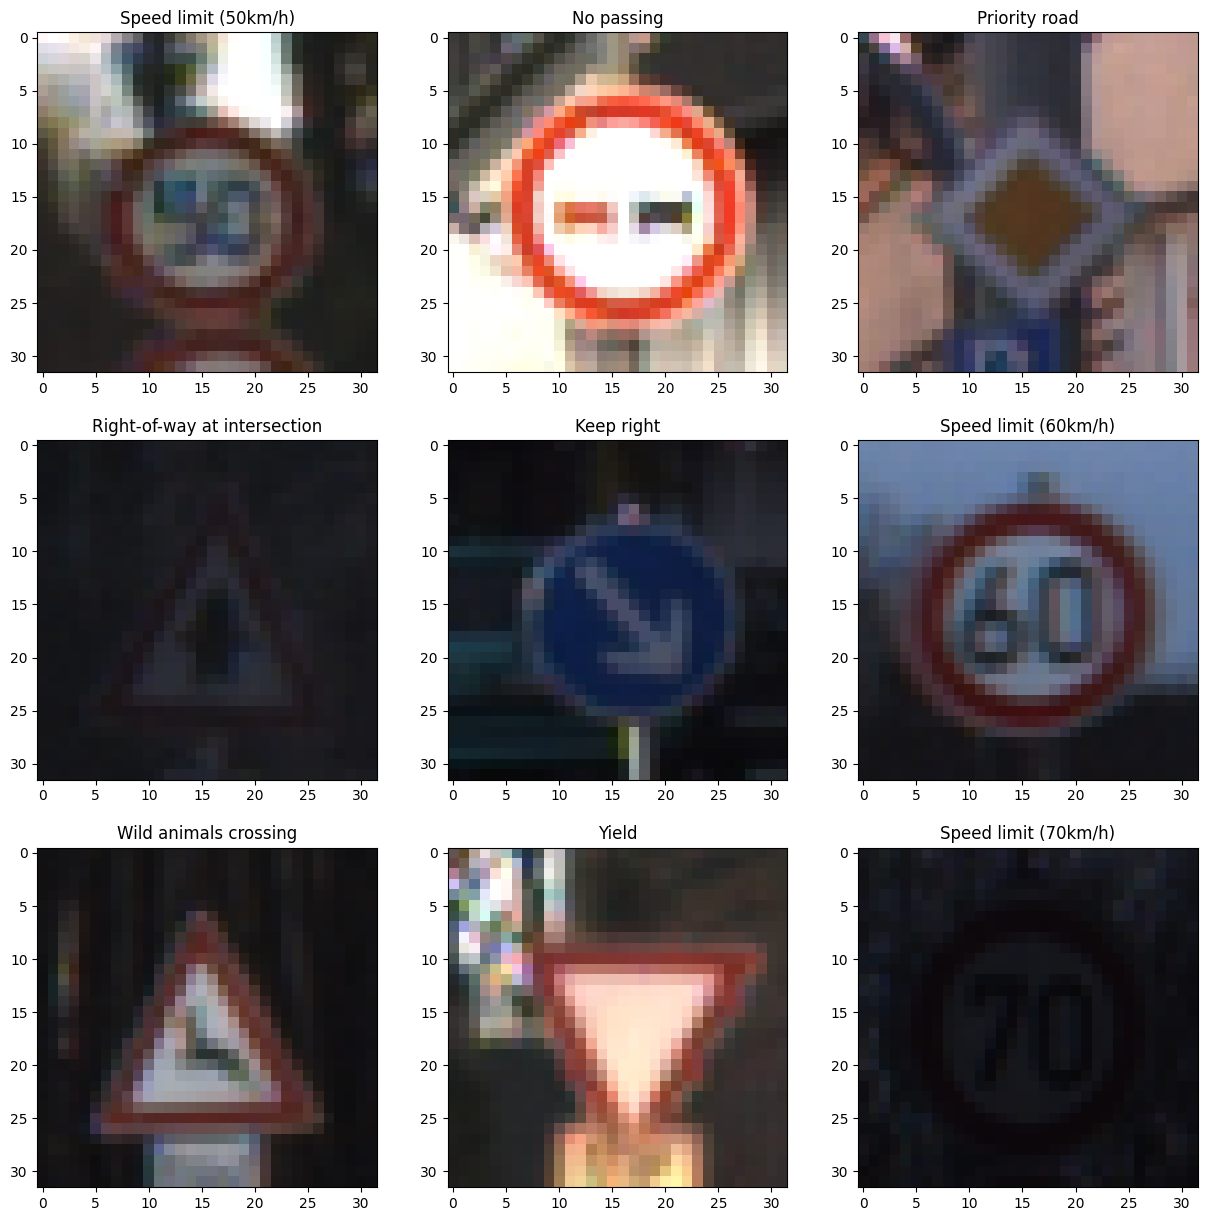

In [12]:
print("\nShape of training data: ", train_data.shape)
print("Shape of test data: ", test_data.shape)
print(f"Number of classes: {num_classes}")
print(f"Images resized to {IMAGE_SIZE} x {IMAGE_SIZE}")

plot_size = 3
random_idxs = [random.randint(0, train_data.shape[0]) for i in range(plot_size**2)]
fig = plt.figure(figsize=(15, 15))
for i, index in enumerate(random_idxs):
    a=fig.add_subplot(plot_size,plot_size, i+1)
    imgplot = plt.imshow(train_data[index])
    a.set_title(label_names[str(train_labels[index]+1)])
plt.show()

Class distribution:

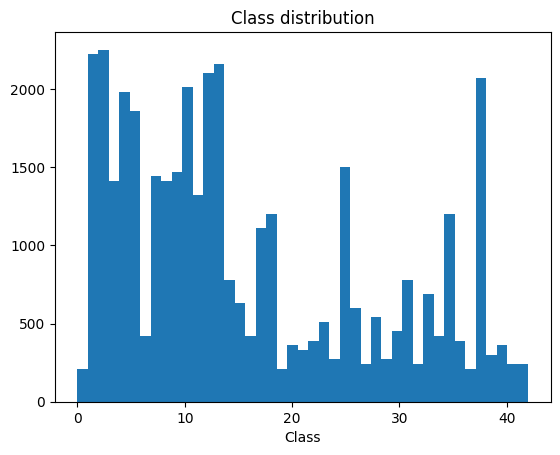

In [13]:
fig, ax = plt.subplots()
values, bins, patches = ax.hist(train_labels, num_classes)
ax.set_xlabel('Class')
ax.set_title('Class distribution')
plt.show()

2) Data Preparation:

A data preparation will be developed once the evaluation for the model is complete, consisting of data augmentation, SMOTE oversampling, and CLAHE implementation.

3) Model Definition and Profiling:

In [1]:
import torch.nn as nn

class TrafficSignCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3,padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ELU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3,padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ELU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=320, kernel_size=3,padding=1),
            nn.ELU(inplace=True),
            nn.Conv2d(in_channels=320, out_channels=256, kernel_size=3,padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ELU(inplace=True),
        )
        
        self.classification = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(16*256, 600),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=600, out_features=256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        X = self.conv(x)
        X = X.view(X.shape[0], -1)
        Y = self.classification(X)
        return Y

C:\Users\alvar\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


4) Training:

In [4]:
from model import TrafficSignCNN
from torch import optim, nn, save
from sklearn.metrics import accuracy_score
import torchvision.transforms as transforms
from matplotlib.pyplot import Axes, gca, figure, savefig
from torch.utils.data import DataLoader
import pickle

# Loading training dataset
train_set = pickle.load(open("serialized_data/train_data_loader", "rb"))

# Parameters 
num_classes = 43
batch_size = 256
learning_rate = 0.001
EPOCHS = 5

# Train function
def train(model, train_set, optimizer, criterion):
    epoch_ls = 0
    epoch_acc = 0
    model.train()
    for batch_idx, (x, y) in enumerate(train_set):
        optimizer.zero_grad()
        y_pred= model(x)
        loss = criterion(y_pred,y)
        loss.backward()
        final_pred = y_pred.argmax(axis=1)
        accuracy = accuracy_score(final_pred,y)
        optimizer.step()
        epoch_ls += loss.item()
        epoch_acc += accuracy
    return epoch_ls / len(train_set), epoch_acc / len(train_set)

# Initializing CNN, Loss function, and optimizer
model = TrafficSignCNN(num_classes)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
transform = transforms.ToTensor()

# Main training logic
train_loss = []
train_accuracy = []
for epoch in range(EPOCHS):
    print("Epoch: ",epoch)
    train_ls, train_acc = train(model, train_set, optimizer, criterion)
    train_loss.append(train_ls)
    train_accuracy.append(train_acc)
    print("Loss: ",train_ls)
    print("Accuracy: ",train_acc)

Epoch:  0
Loss:  2.7836401578667878
Accuracy:  0.2109473986379474
Epoch:  1
Loss:  0.7818030549527762
Accuracy:  0.7392080099778271
Epoch:  2
Loss:  0.17900336006438577
Accuracy:  0.9410325764174851
Epoch:  3
Loss:  0.07361690508951614
Accuracy:  0.976359577922078
Epoch:  4
Loss:  0.04920297532112568
Accuracy:  0.9840644302343997


Plotting loss and accuracy over time:

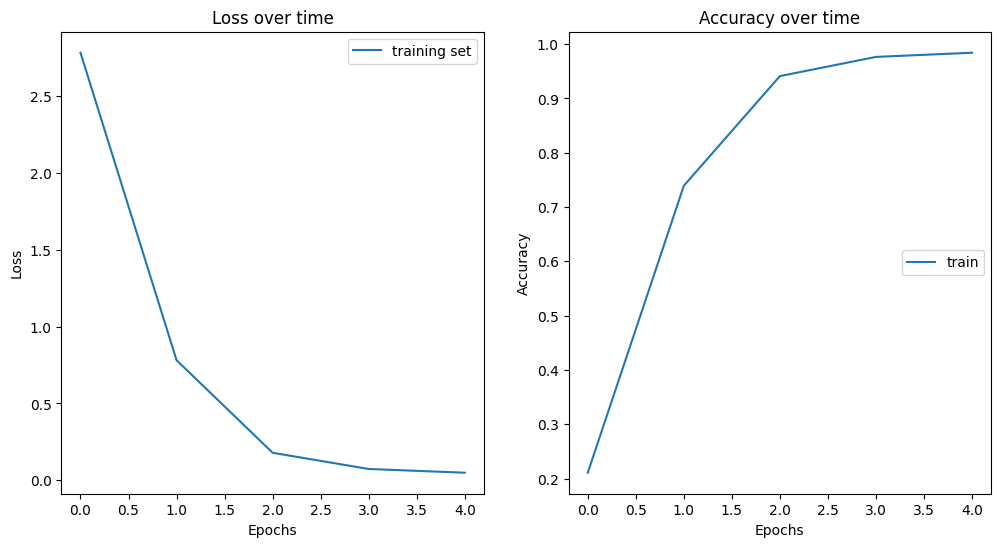

In [7]:
import matplotlib.pyplot as plt

_, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(train_loss, label="training set")
axs[0].set_title("Loss over time")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
legend = axs[0].legend(loc='upper right')
axs[1].plot(train_accuracy, label="train")
axs[1].set_title("Accuracy over time")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
legend = axs[1].legend(loc='center right')
plt.show()

5) Evaluation:

In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import torch

# Loading test dataset
test_set = pickle.load(open("serialized_data/test_data_loader", "rb"))

true_labels = []
pred_labels = []

with torch.no_grad():
    model.eval()
    y_right = 0
    for idx, (x, y) in enumerate(test_set):
        y_pred = model(x)
        final_pred = y_pred.argmax(axis=1)
        if y.item() == final_pred.item():
            y_right += 1
        pred_labels.append(final_pred.item())
        true_labels.append(y.item())

print(f"Correctly classified images: {y_right}")
print(f"Incorrectly classified images: {len(test_set)-y_right}")
print(f"Final Model Accuracy: {y_right/len(test_set)}")
print(classification_report(true_labels,pred_labels))

Correctly classified images: 11484
Incorrectly classified images: 1146
Final Model Accuracy: 0.9092636579572446
              precision    recall  f1-score   support

           0       0.47      0.82      0.60        60
           1       0.96      0.88      0.92       720
           2       0.90      0.97      0.94       750
           3       0.88      0.93      0.90       450
           4       0.97      0.94      0.96       660
           5       0.83      0.93      0.88       630
           6       1.00      0.70      0.82       150
           7       0.94      0.83      0.88       450
           8       0.94      0.86      0.90       450
           9       1.00      0.91      0.95       480
          10       0.96      0.96      0.96       660
          11       0.90      0.90      0.90       420
          12       0.95      0.90      0.92       690
          13       0.96      0.99      0.98       720
          14       0.99      1.00      0.99       270
          15       0.95